# Testing cluster finder

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import time 
import h5py
import numpy as np
import aare
import boost_histogram as bh
import seaborn as sns
import pickle

#Debugging
import torch

from simple_eta import plot_cluster_finding
from simple_eta import generate, Generator


g = Generator.fromJSON('moench_g4_hg.json')
g.device = 'mps'
g.photon_energy = 8.0
g.image_size = (10,15)

tag = '_B'

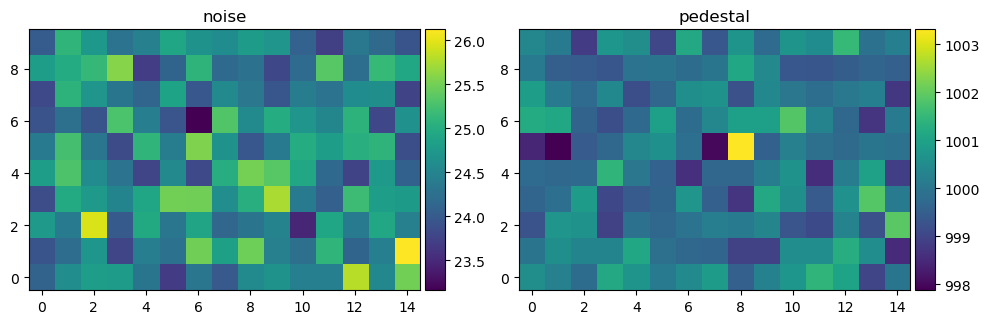

In [16]:
#Create cluster finder and initialize pedestal
cf = aare.ClusterFinder(g.image_size)
for i in range(1000):
    cf.push_pedestal_frame(g.dark())

#plotting
fig, axs = plt.subplots(1,2, figsize = (10,5))
im = axs[0].imshow(cf.noise, origin = 'lower')
axs[0].set_title('noise')
aare.add_colorbar(axs[0], im)
im = axs[1].imshow(cf.pedestal, origin = 'lower')
axs[1].set_title('pedestal')
aare.add_colorbar(axs[1], im)
fig.tight_layout()

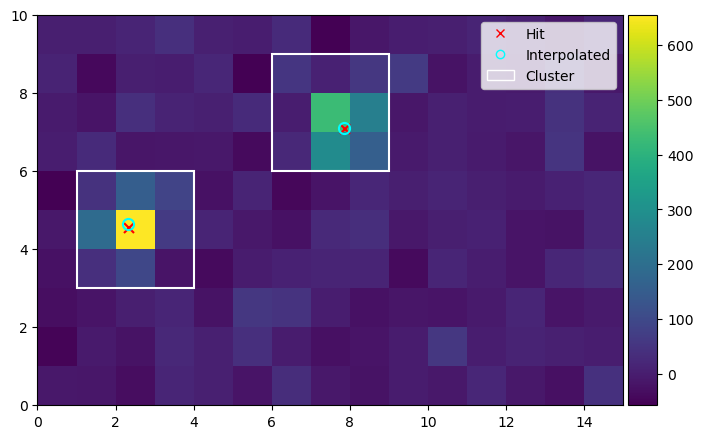

In [86]:
#Load ETA for interpolation
with open(f".data/test_{g.grid_size}x{g.grid_size}{tag}.pkl", "rb") as f:
    eta_hist = pickle.load(f)
    
etabinsx = np.array(eta_hist.axes.edges.T[0].flat)
etabinsy = np.array(eta_hist.axes.edges.T[1].flat)
ebins = np.array(eta_hist.axes.edges.T[2].flat)
p = aare.Interpolator(eta_hist, etabinsx, etabinsy, ebins)

n_photons = 2

image, hits = g.sparse(n_photons)
cf.find_clusters(image)
clusters = cf.steal_clusters()
interpolated_hits = p.interpolate(clusters)


fig, ax = plot_cluster_finding(image = image-cf.pedestal, clusters = clusters, hits = hits, interpolated_hits = interpolated_hits)

In [38]:
err_hist = bh.Histogram(
    bh.axis.Regular(50, 0, 10) #um
)
hist = bh.Histogram(
    bh.axis.Regular(50, 0, 12) #um
)

n_photons = 1
n_frames = 1000

for i in range(n_frames):
    image, hit_pos = g.sparse(n_photons)
    cf.find_clusters(image)
    clusters = cf.steal_clusters()
    arr = np.array(clusters)

    x,y = hit_pos[:,0], hit_pos[:,1]

    interpolated_hits = p.interpolate(clusters)
    error = np.sqrt(np.abs(interpolated_hits['x']-x)**2+np.abs(interpolated_hits['y']-y)**2)
    err_hist.fill(error*g.pixel_size)
    hist.fill(clusters.sum()/g.gain)

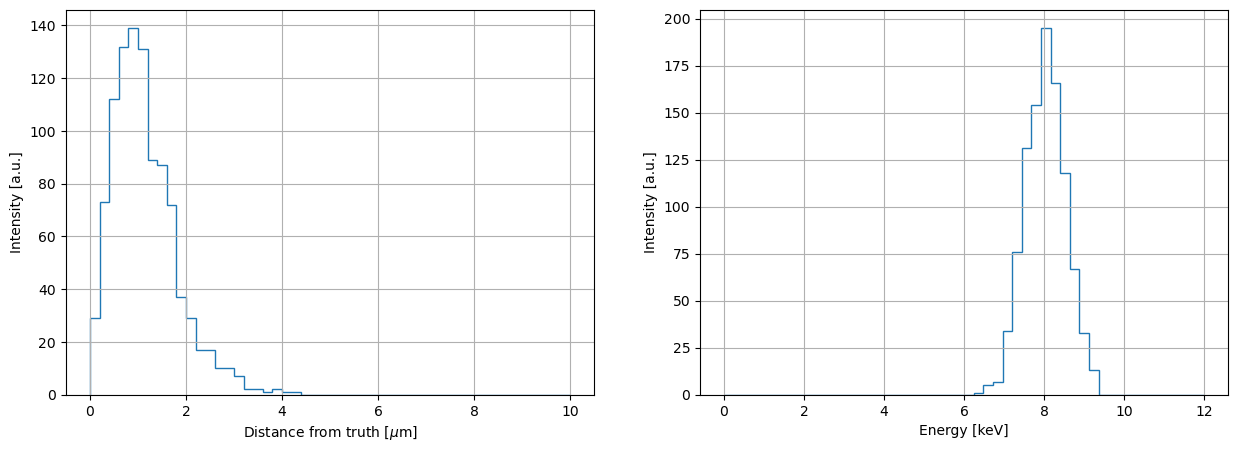

In [40]:


fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].stairs(err_hist.values(), err_hist.axes[0].edges);
axs[0].set_xlabel(r'Distance from truth [$\mu$m]')
axs[0].set_ylabel('Intensity [a.u.]')



axs[1].stairs(hist.values(), hist.axes[0].edges);
axs[1].set_xlabel(r'Energy [keV]')
axs[1].set_ylabel('Intensity [a.u.]')

for ax in axs:
    ax.grid()